In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import MSELoss
import time

from laser_jitter.data import TimeSeries, TimeSeriesSTFT
from laser_jitter.model_basic import LSTMForecaster
from laser_jitter.model import RNNTemporal
from laser_jitter.train import train_model
from laser_jitter.inference import predict_on_series

In [2]:
N = 5
smooth_params = {
    'kernel': np.ones(N)/N,
}

data = pd.read_csv("/home/wi73yus/focus_deviation/data/cryo07_decFULL.csv", header=None)
data = data.rename({0: 'real_time', 1:'focus_location'}, axis=1)
data['time_idx'] = np.arange(len(data['real_time']))

ts_data = np.array(data['focus_location'])

### TimeSeries

In [3]:
ts = TimeSeries(ts_data[:10000], smooth_params=smooth_params, train_size=0.8)

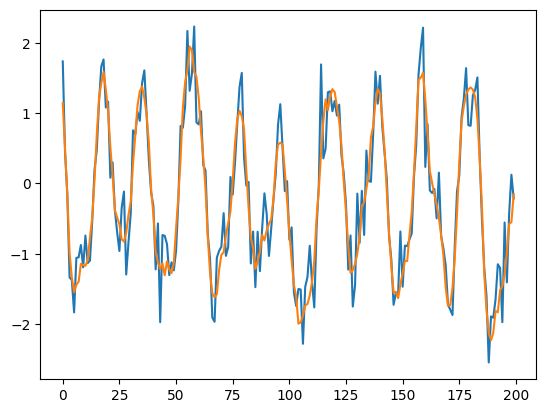

In [4]:
idx = 200
plt.figure()
plt.plot(ts.test[:idx])
plt.plot(ts.test_smooth[:idx])
plt.show()

In [5]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders
loaders_smooth = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                       dataloader_params)
trainloader_smooth, testloader_smooth = loaders_smooth

In [6]:
for (x,y), (x_smooth, y_smooth) in zip(trainloader, trainloader_smooth):
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 1]) torch.Size([64, 100, 1])


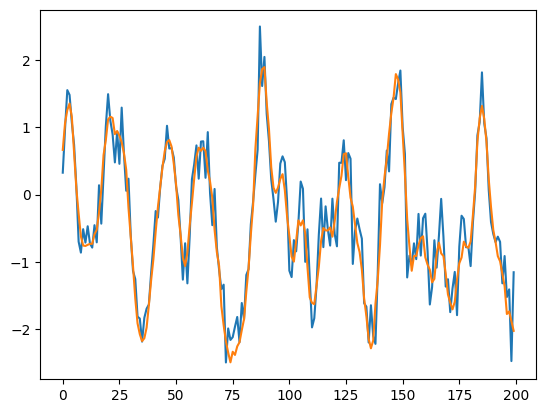

In [7]:
i = 50
idx = 200
plt.figure()
plt.plot(x[i,:idx])
plt.plot(x_smooth[i,:idx])
plt.show()

### TimeSeriesSTFT

In [8]:
stft_params = {
    'nperseg': 500, # window_length
    'fs': 1e3,
    'boundary': None,
    'noverlap': 499,
    'padded': False,
    'window': 'tukey'
}

filter_params = {
    'thresh_weight': 1,
    'freq_low': 0
}

ts = TimeSeriesSTFT(ts_data[:10000], stft_params, train_size=0.8, filter_params=filter_params)

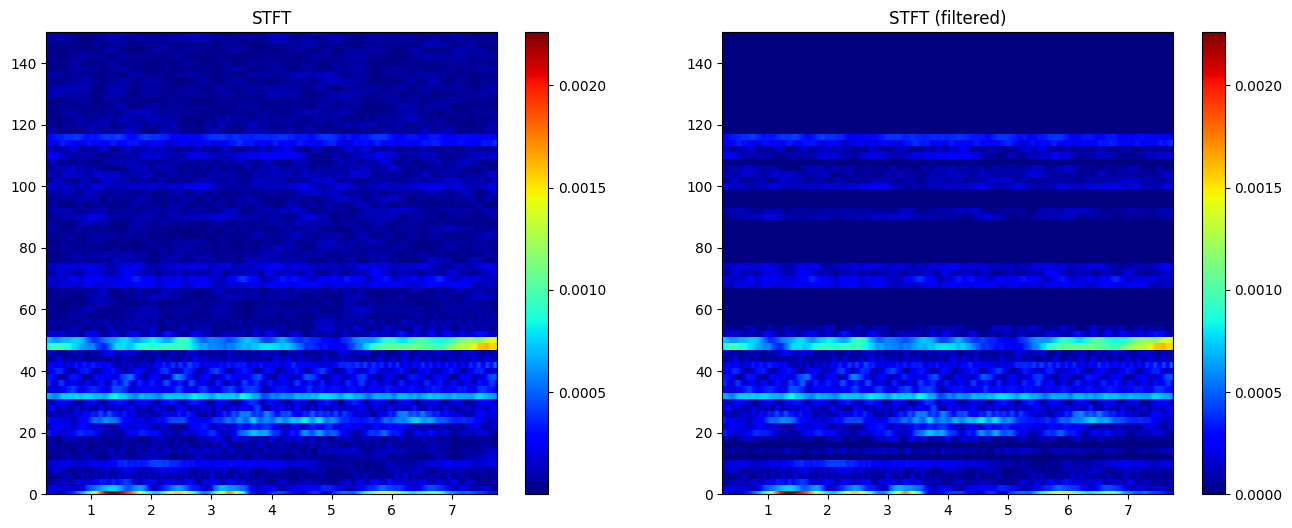

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT')


plt.subplot(122)
plt.pcolormesh(ts.t, ts.freq, np.abs(ts.train_stft_filt), cmap='jet')
plt.colorbar()
plt.ylim([0,150])
plt.title('STFT (filtered)')
plt.show()

In [10]:
sequence_params = {
    'training_window': 200,
    'prediction_window': 100,
    'step': 1
}

dataloader_params = {
    'batch_size': 64,
    'shuffle': False,
    'drop_last': False,
}


loaders = ts.create_dataloaders(ts.train_real, ts.train_imag, ts.test_real, ts.test_imag,
                                sequence_params, dataloader_params)
trainloader, testloader = loaders

In [11]:
for x,y in trainloader:
    print(x.shape, y.shape)
    break

torch.Size([64, 200, 80]) torch.Size([64, 100, 80])


### Basic_model

In [24]:
n_features = 1
training_window = 200
prediction_window = 100
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
batch_size = 1

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 128,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 3,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}

model = LSTMForecaster(**model_params)
x = torch.Tensor(np.random.uniform(size=(batch_size,training_window,n_features)))#.to(device)
print(x.shape)

prediction = model(x).detach().cpu().numpy()
prediction = prediction.reshape((batch_size,prediction_window,n_features))

print(prediction.shape)

torch.Size([1, 200, 1])
(1, 100, 1)


### Train basic model

In [3]:
smooth_params = {
    'kernel': np.ones(N)/N,
}

ts = TimeSeries(ts_data, smooth_params=smooth_params, train_size=0.8)

training_window = 200
prediction_window = 100
sequence_params = {
    'training_window': training_window,
    'prediction_window': prediction_window,
    'step': 1
}

dataloader_params = {
    'batch_size': 128,
    'drop_last': False,
}

loaders = ts.create_dataloaders(ts.train, ts.test, sequence_params, dataloader_params)
trainloader, testloader = loaders

loaders = ts.create_dataloaders(ts.train_smooth, ts.test_smooth, sequence_params,
                                dataloader_params)
trainloader_smooth, testloader_smooth = loaders

In [4]:
n_features = 1
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'

model_params = {
    'n_features': n_features,
    'n_hidden_lstm': 128,
    'n_hidden_fc': 500,
    'n_outputs': prediction_window*n_features,
    'sequence_len': training_window,
    'n_lstm_layers': 2,
    'n_deep_layers': 1,
    'dropout': 0.2,
    'use_cuda': use_cuda
}
save_path = 'models/rnn/rnn.pth'

model = LSTMForecaster(**model_params).to(device)
model_high_level = RNNTemporal(model_params, model, save_path)

In [5]:
lr = 2e-4
n_epochs = 30

# Initialize the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.AdamW(model_high_level.model.parameters(), lr=lr)

In [28]:
losses = model_high_level.train(trainloader_smooth, testloader_smooth,
                                criterion, optimizer, n_epochs=n_epochs)

0 - train: 0.4176530760478198, valid: 0.25259151181270334
1 - train: 0.24093843633081855, valid: 0.23131166963741698
2 - train: 0.22252774965472338, valid: 0.21678494636354775
3 - train: 0.21260434280081494, valid: 0.21306914502176746
4 - train: 0.20377698274162726, valid: 0.2045274587540791
5 - train: 0.19373564724999714, valid: 0.19842596737475232
6 - train: 0.18406994871007717, valid: 0.18651647994230533
7 - train: 0.17481855127384993, valid: 0.181378120235328
8 - train: 0.1667537488103882, valid: 0.17539216937689944
9 - train: 0.159008778692261, valid: 0.1721328481517989
10 - train: 0.15220588154909087, valid: 0.17102243031921058
11 - train: 0.14619201857869218, valid: 0.1704728641900523
12 - train: 0.13887892396954016, valid: 0.17230936884880066
13 - train: 0.13269689782121316, valid: 0.17225581536005283
14 - train: 0.1250398970716368, valid: 0.17822149344559374
15 - train: 0.11712445470133448, valid: 0.17854089341286955
16 - train: 0.10759841202478099, valid: 0.18195322644093942


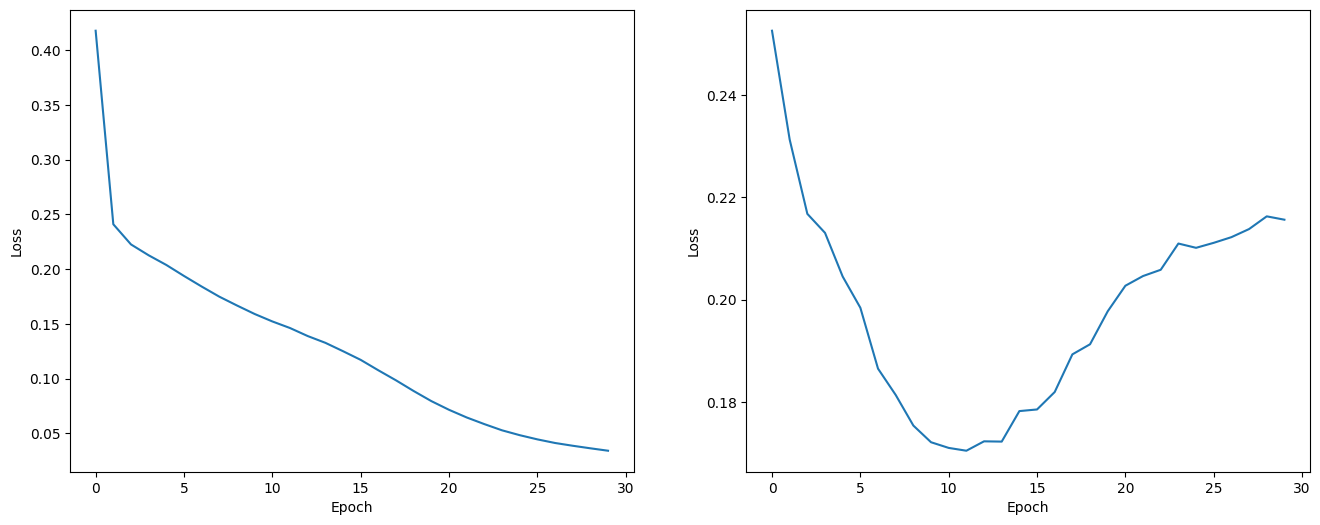

In [29]:
plt.figure(figsize=(16,6))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(losses[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
plt.show()

#### Inference

In [11]:
model = model_high_level.load_best_model()

data, metrics = model_high_level.inference_on_dataloader(model, testloader, testloader_smooth)
predictions, actuals, actuals_smooth = data
print(predictions.shape)

n_batches = len(predictions)
predictions = ts.inverse_transform_series(predictions.flatten())
predictions = predictions.reshape((n_batches,prediction_window))
actuals_smooth = ts.inverse_transform_series(actuals_smooth.flatten())
actuals_smooth = actuals_smooth.reshape((n_batches,prediction_window))
actuals = ts.inverse_transform_series(actuals.flatten(), scaler=ts.scaler)
actuals = actuals.reshape((n_batches,prediction_window))

metrics = [ts.inverse_transform_series(np.array([metric])).squeeze() for metric in metrics]

(3700, 100)


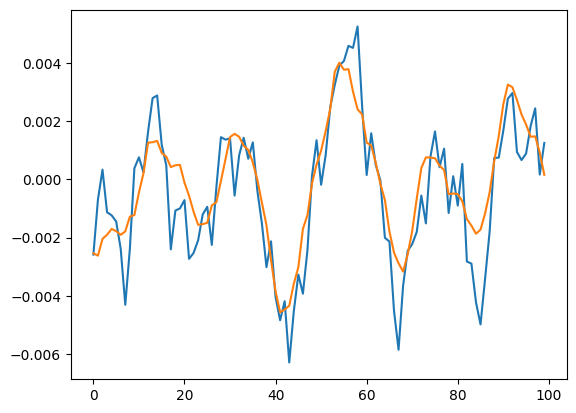

In [12]:
idx = 2500
plt.figure()
plt.plot(actuals[idx])
plt.plot(predictions[idx])
plt.show()

In [13]:
print(f'mae: {metrics[0]}')
print(f'rms: {metrics[1]}')

mae: 0.0011009087320417166
rms: 0.0013542461674660444


In [14]:
# use_cuda = torch.cuda.is_available()
models = []
save_path = 'models/rnn/rnn.pth'
for use_cuda in [False, True]:
    device = 'cuda' if use_cuda else 'cpu'
    
    model_params = {
        'n_features': n_features,
        'n_hidden_lstm': 128,
        'n_hidden_fc': 500,
        'n_outputs': prediction_window*n_features,
        'sequence_len': training_window,
        'n_lstm_layers': 2,
        'n_deep_layers': 1,
        'dropout': 0.2,
        'use_cuda': use_cuda
    }

    model = LSTMForecaster(**model_params).to(device)
    model_high_level = RNNTemporal(model_params, model, save_path)
    model_high_level.load_best_model()
    models.append(model_high_level)

In [15]:
t0 = 17500
N = 5

past_start, past_end = t0-N//2, t0+training_window+N//2 
future_start, future_end = t0+training_window+N//2, t0+training_window+N//2+prediction_window
series_past = ts.series[past_start:past_end].squeeze()
series_future = ts.series[future_start:future_end].squeeze()

predictions = []
devices = ['cpu', 'cuda']
for i,device in enumerate(devices):
    models[i].model.eval()
    t_start = time.time()
    prediction = predict_on_series(series_past, ts, models[i], device=device)
    t_pred = time.time() - t_start
    predictions.append(prediction)
    print('Prediction time ({}): {:3.1f} ms'.format(device, t_pred*1e3))

cpu
Prediction time (cpu): 35.6 ms
cuda:0
Prediction time (cuda): 2.2 ms


rms (initial): 0.002468301142486467
rms          : 0.0018066067659630468


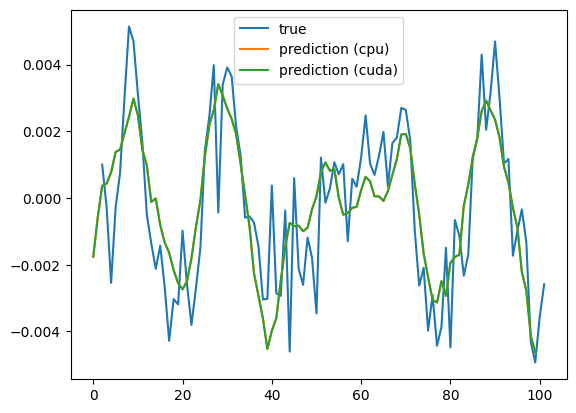

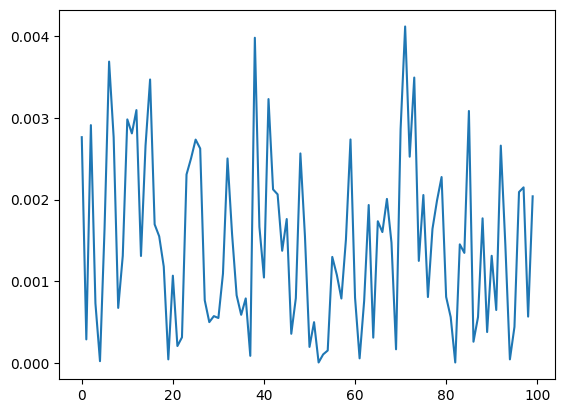

In [20]:
err = np.abs(series_future - prediction)
rms_ini = np.sqrt(np.mean(series_future**2))
rms = np.sqrt(np.mean(err**2))
print(f'rms (initial): {rms_ini}')
print(f'rms          : {rms}')

plt.figure()
plt.plot(np.arange(prediction_window)+2, series_future, label='true')
for i in range(2):
    plt.plot(predictions[i], label=f'prediction ({devices[i]})')
plt.legend()
plt.show()

plt.figure()
plt.plot(np.abs(series_future - prediction))
plt.show()